In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model


Data Loading

In [3]:
class AutoEncoder(Model):
    def __init__(self,latent_dim,shape):
        super(AutoEncoder,self).__init__()
        self.latent_dim = latent_dim
        self.shape = shape

        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(150, 150, 3)),  # Grayscale Input
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)
        ])

        # Decoder: Reconstructs a color image
        self.decoder = tf.keras.Sequential([
        layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2),
        layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2),
        layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same', strides=2),
        
        # Last layer should output 3 channels (RGB)
        layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same'),  # 3 channels for color output
        
        # Crop extra pixels to match (150,150,3)
        layers.Cropping2D(((1, 1), (1, 1)))  
        ])


        
    def call(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



In [4]:
import os
import shutil
import random

# Set paths for input and output image folders
input_folder = '/kaggle/input/landscape-image-colorization/landscape Images/gray'
output_folder = '/kaggle/input/landscape-image-colorization/landscape Images/color'

# Set paths for train, validation, and test directories
train_input_folder = '/kaggle/working/to/train_input'
train_output_folder = '/kaggle/working/to/train_output'
val_input_folder = '/kaggle/working/to/val_input'
val_output_folder = '/kaggle/working/to/val_output'
test_input_folder = '/kaggle/working/to/test_input'
test_output_folder = '/kaggle/working/to/test_output'

# Create necessary directories if they don't e

# Create necessary directories if they don't exist
os.makedirs(train_input_folder, exist_ok=True)
os.makedirs(train_output_folder, exist_ok=True)
os.makedirs(val_input_folder, exist_ok=True)
os.makedirs(val_output_folder, exist_ok=True)
os.makedirs(test_input_folder, exist_ok=True)
os.makedirs(test_output_folder, exist_ok=True)

# List all images in the input folder (assuming both input and output images have the same filenames)
input_images = sorted(os.listdir(input_folder))
output_images = sorted(os.listdir(output_folder))

# Ensure that input and output images are paired correctly (same names)
assert input_images == output_images, "Input and output images do not match!"

# Shuffle the image pairs
image_pairs = list(zip(input_images, output_images))
random.shuffle(image_pairs)

# Split the data (70% train, 20% validation, 10% test)
train_size = int(len(image_pairs) * 0.7)
val_size = int(len(image_pairs) * 0.2)

train_pairs = image_pairs[:train_size]
val_pairs = image_pairs[train_size:train_size + val_size]
test_pairs = image_pairs[train_size + val_size:]

# Move files to the respective folders
for input_img, output_img in train_pairs:
    shutil.copy(os.path.join(input_folder, input_img), os.path.join(train_input_folder, input_img))
    shutil.copy(os.path.join(output_folder, output_img), os.path.join(train_output_folder, output_img))

for input_img, output_img in val_pairs:
    shutil.copy(os.path.join(input_folder, input_img), os.path.join(val_input_folder, input_img))
    shutil.copy(os.path.join(output_folder, output_img), os.path.join(val_output_folder, output_img))

for input_img, output_img in test_pairs:
    shutil.copy(os.path.join(input_folder, input_img), os.path.join(test_input_folder, input_img))
    shutil.copy(os.path.join(output_folder, output_img), os.path.join(test_output_folder, output_img))

print(f"Training data size: {len(train_pairs)} images")
print(f"Validation data size: {len(val_pairs)} images")
print(f"Test data size: {len(test_pairs)} images")

Training data size: 4990 images
Validation data size: 1425 images
Test data size: 714 images


In [5]:
import cv2

# Load an image
image = cv2.imread("/kaggle/input/landscape-image-colorization/landscape Images/gray/0.jpg")

# Get the shape
height, width, channels = image.shape
print(f"Image Shape: Height={height}, Width={width}, Channels={channels}")


Image Shape: Height=150, Width=150, Channels=3


In [6]:
def load_images(folder, img_size=(150, 150)):
    images = []
    for filename in sorted(os.listdir(folder)):  
        img_path = os.path.join(folder, filename)
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        img = cv2.resize(img, img_size)  # Resize to (150,150)
        
        # Convert grayscale to 3-channel image
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        images.append(img)

    return np.array(images, dtype=np.float32) / 255.0

def load_imagesc(folder, img_size=(150, 150)):  
    images = []
    for filename in sorted(os.listdir(folder)):  
        img_path = os.path.join(folder, filename)
        
        # Load the image in color mode
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  
        if img is None:
            continue  # Skip if the image cannot be loaded
        
        # Resize to (150,150)
        img = cv2.resize(img, img_size)  

        # Convert BGR to RGB (OpenCV loads in BGR format)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        images.append(img)

    # Convert to numpy array and normalize pixel values to [0,1]
    return np.array(images, dtype=np.float32) / 255.0  

# Set paths to train input/output images

# Load images
X_train = load_images(train_input_folder)
Y_train = load_imagesc(train_output_folder)

X_val = load_images(val_input_folder)
Y_val = load_imagesc(val_output_folder)

print(f"Training data shape: {X_train.shape}, {Y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {Y_val.shape}")

Training data shape: (4990, 150, 150, 3), (4990, 150, 150, 3)
Validation data shape: (1425, 150, 150, 3), (1425, 150, 150, 3)


In [7]:
X_train[0].shape

(150, 150, 3)

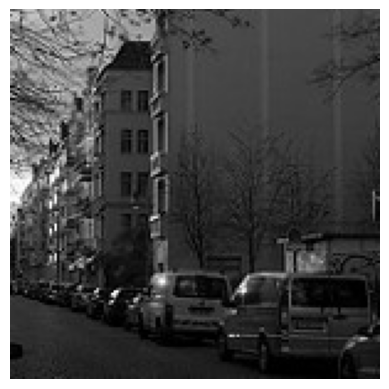

In [8]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0])  # Display the image
plt.axis("off")  # Hide axis
plt.show()


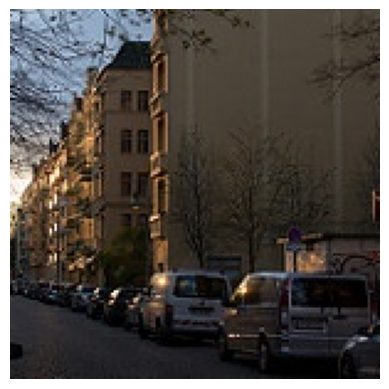

In [9]:


plt.imshow(Y_train[0])  # Display the image
plt.axis("off")  # Hide axis
plt.show()


In [10]:
import tensorflow.keras.backend as K
import tensorflow.image as tf_img

# Function for PSNR metric
def psnr_metric(y_true, y_pred):
    return tf.reduce_mean(tf_img.psnr(y_true, y_pred, max_val=1.0))

# Function for SSIM metric
def ssim_metric(y_true, y_pred):
    return tf.reduce_mean(tf_img.ssim(y_true, y_pred, max_val=1.0))

In [11]:
# Define input shape and latent space size
image_shape = (150, 150, 3)  # Adjust this based on your dataset
latent_dim = 108  # You can tune this

# Initialize autoencoder
autoencoder = AutoEncoder(latent_dim, image_shape)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse',metrics=[psnr_metric, ssim_metric])

# Train the autoencoder
history=autoencoder.fit(
    X_train, Y_train, 
    validation_data=(X_val, Y_val),
    epochs=60,  
    batch_size=32
)


Epoch 1/60
156/156 ━━━━━━━━━━━━━━━━━━━━ 477s 3s/step - loss: 0.0516 - psnr_metric: 13.9976 - ssim_metric: 0.2679 - val_loss: 0.0182 - val_psnr_metric: 18.1356 - val_ssim_metric: 0.4664
Epoch 2/60
156/156 ━━━━━━━━━━━━━━━━━━━━ 466s 3s/step - loss: 0.0179 - psnr_metric: 18.2925 - ssim_metric: 0.4919 - val_loss: 0.0156 - val_psnr_metric: 18.8601 - val_ssim_metric: 0.5574
Epoch 3/60
156/156 ━━━━━━━━━━━━━━━━━━━━ 514s 3s/step - loss: 0.0155 - psnr_metric: 18.9134 - ssim_metric: 0.5653 - val_loss: 0.0140 - val_psnr_metric: 19.3781 - val_ssim_metric: 0.6024
Epoch 4/60
156/156 ━━━━━━━━━━━━━━━━━━━━ 466s 3s/step - loss: 0.0142 - psnr_metric: 19.3236 - ssim_metric: 0.6025 - val_loss: 0.0134 - val_psnr_metric: 19.6022 - val_ssim_metric: 0.6213
Epoch 5/60
156/156 ━━━━━━━━━━━━━━━━━━━━ 518s 3s/step - loss: 0.0135 - psnr_metric: 19.5308 - ssim_metric: 0.6243 - val_loss: 0.0126 - val_psnr_metric: 19.8338 - val_ssim_metric: 0.6489
Epoch 6/60
156/156 ━━━━━━━━━━━━━━━━━━━━ 513s 3s/step - loss: 0.0130 - psnr_

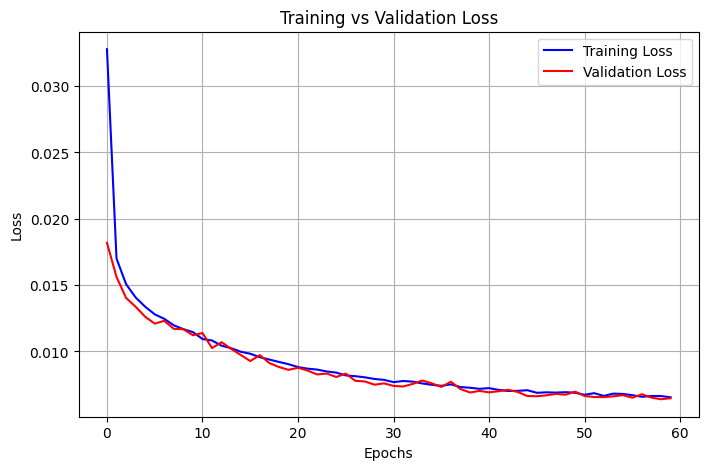

In [12]:
import matplotlib.pyplot as plt

# Extract loss values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss curves
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step


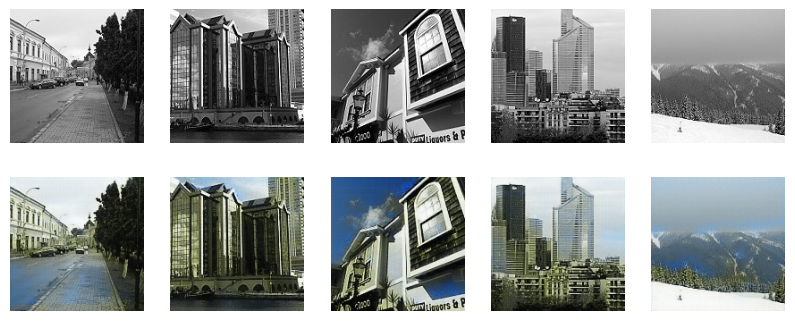

In [13]:
# Load test images
X_test = load_images(test_input_folder)

# Get reconstructed images
reconstructed_images = autoencoder.predict(X_test)

# Display original vs. reconstructed images
import matplotlib.pyplot as plt

n = 5  # Number of images to visualize
plt.figure(figsize=(10, 4))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(150, 150,3))
    plt.axis('off')
    
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].reshape(150, 150,3))
    plt.axis('off')

plt.show()

In [14]:
encoded_imgs = autoencoder.encoder(X_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

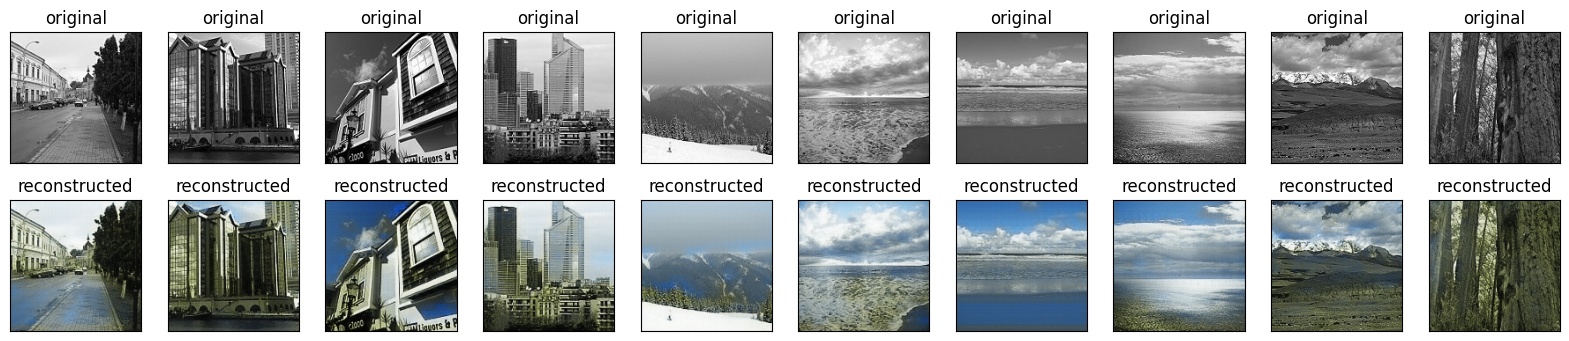

In [15]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Metrics

In [16]:
Y_test = load_imagesc(test_input_folder)

In [17]:
# After training, you can evaluate the model:
test_loss, test_psnr, test_ssim = autoencoder.evaluate(X_test, Y_test)  # Use your test data
print(f"Test Loss: {test_loss}")
print(f"Test PSNR: {test_psnr}")
print(f"Test SSIM: {test_ssim}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 0.0048 - psnr_metric: 23.8622 - ssim_metric: 0.9092
Test Loss: 0.004785052500665188
Test PSNR: 23.904743194580078
Test SSIM: 0.9107025265693665


In [18]:
import tensorflow.image as tf_img
import numpy as np

# Get predictions on test data
predictions = autoencoder.predict(X_test)

# Calculate MSE manually
mse = np.mean(np.square(Y_test - predictions))
print(f"Test MSE: {mse}")

# Calculate PSNR (Peak Signal-to-Noise Ratio) manually
psnr = np.mean(tf_img.psnr(Y_test, predictions, max_val=1.0))
print(f"Test PSNR: {psnr}")

# Calculate SSIM (Structural Similarity Index) manually
ssim = np.mean(tf_img.ssim(Y_test, predictions, max_val=1.0))
print(f"Test SSIM: {ssim}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step
Test MSE: 0.004785052500665188
Test PSNR: 23.907562255859375
Test SSIM: 0.9104496240615845


# Mean Squared Error (MSE)

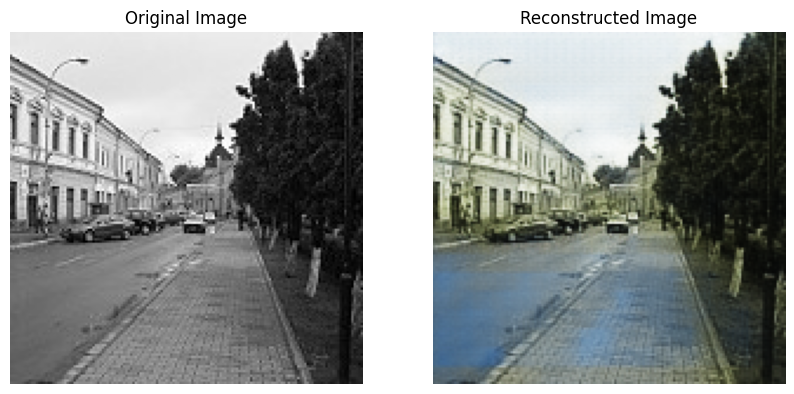

In [19]:
import matplotlib.pyplot as plt

# Show the original and reconstructed images
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(Y_test[0])  # Display original image
plt.title("Original Image")
plt.axis("off")

# Reconstructed image
plt.subplot(1, 2, 2)
plt.imshow(predictions[0])  # Display reconstructed image
plt.title("Reconstructed Image")
plt.axis("off")

plt.show()


Interpretation:

    MSE quantifies the average squared difference between the original and the reconstructed image. A lower MSE means the reconstruction is closer to the original image.
    Scale: A smaller value indicates better reconstruction. Ideally, you want MSE to be as low as possible, but this varies depending on the image data and model architecture.

 # Peak Signal-to-Noise Ratio (PSNR):

In [20]:
print(f"PSNR: {psnr} dB")


PSNR: 23.907562255859375 dB


Interpretation:

    PSNR measures the quality of the reconstructed image. A higher PSNR indicates a better reconstruction. It’s the ratio between the maximum possible power of an image and the power of the noise.
    Scale: Typical PSNR values range from 20 to 40 for image reconstruction tasks, with higher values being better. PSNR > 30 dB is generally considered a good result.

# Structural Similarity Index (SSIM):

In [21]:
import tensorflow as tf
ssim_map = tf.image.ssim(Y_test[0], predictions[0], max_val=1.0)
print(f"SSIM: {ssim_map}")


SSIM: 0.9112429618835449


Interpretation:

    SSIM measures the perceived quality of the image by comparing structural information between the original and reconstructed images. It ranges from -1 to 1, where 1 indicates perfect similarity.
    Scale: A value closer to 1 indicates better structural similarity between the images. Typically, SSIM > 0.9 is considered good.